In [6]:
from copy import deepcopy
import pandas as pd
import numpy as np
import scipy.linalg
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

In [2]:
data = pd.read_csv('datafiles/rgofull_nan.csv').drop(columns=['type', 'obs_umbral_area', 'corr_umbral_area'])
data['obs_time'] = pd.to_datetime(data['obs_time'])

In [3]:
grouped_data = data.groupby('id')
bad_indices = grouped_data.size()[grouped_data.size() > 16].index
data = data.drop(data.index[np.isin(data.id, bad_indices)])

In [4]:
data.head()

,obs_time,id,obs_whole_area,corr_whole_area,center_dist,pos_angle,carrington_lon,lat,center_meridian_dist
0,1874-05-09 11:55:40,8600,639.0,378.0,0.535,71.1,171.6,7.4,-30.7
1,1874-05-09 11:55:40,8700,1159.0,852.0,0.733,96.8,155.1,-7.0,-47.2
2,1874-05-09 11:55:40,8800,84.0,68.0,0.783,299.3,249.1,20.5,46.8
3,1874-05-10 00:00:00,8500,169.0,167.0,0.862,265.7,248.5,-5.2,59.7
4,1874-05-10 00:00:00,8600,541.0,287.0,0.334,58.5,172.2,7.3,-16.7


## Filtration

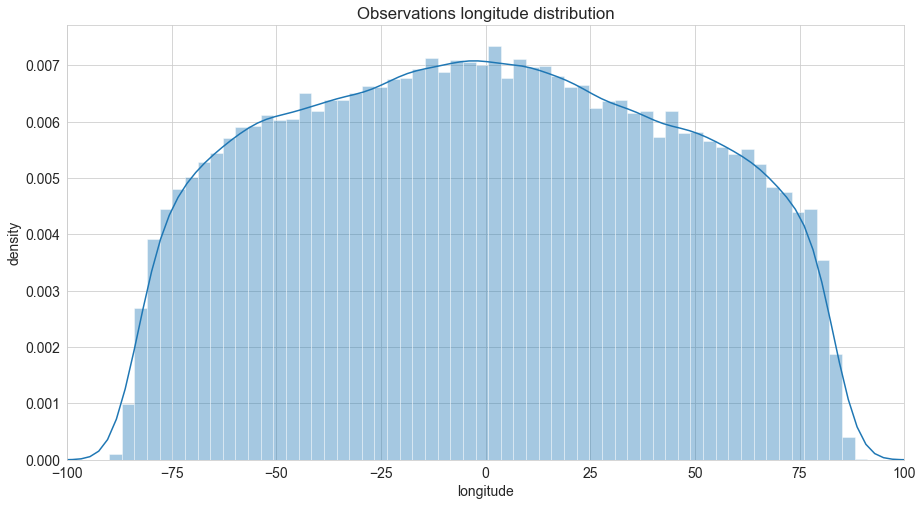

In [7]:
plt.figure(figsize=(15, 8))
sns.distplot(data.center_meridian_dist.dropna(), bins=80)
plt.xlim(-100, 100)
plt.xlabel('longitude')
plt.ylabel('density')
plt.title('Observations longitude distribution')
plt.show()

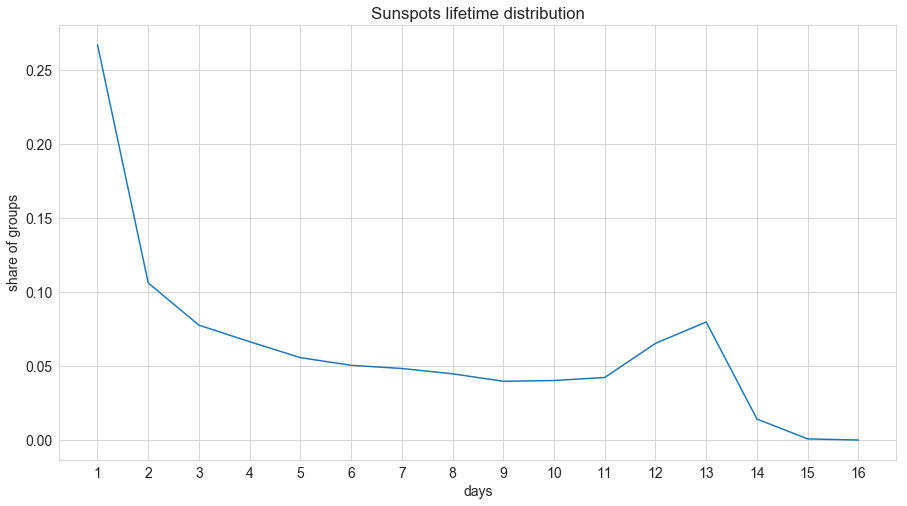

In [19]:
plt.figure(figsize=(15, 8))
grouped_data = data.groupby('id')
unique, counts = np.unique(grouped_data.size(), return_counts=True)
sns.lineplot(unique, counts / counts.sum())
plt.xlabel('days')
plt.ylabel('share of groups')
plt.xticks(np.arange(1, 17))
#plt.xlim(-1, 16)
plt.title('Sunspots lifetime distribution')
plt.show()

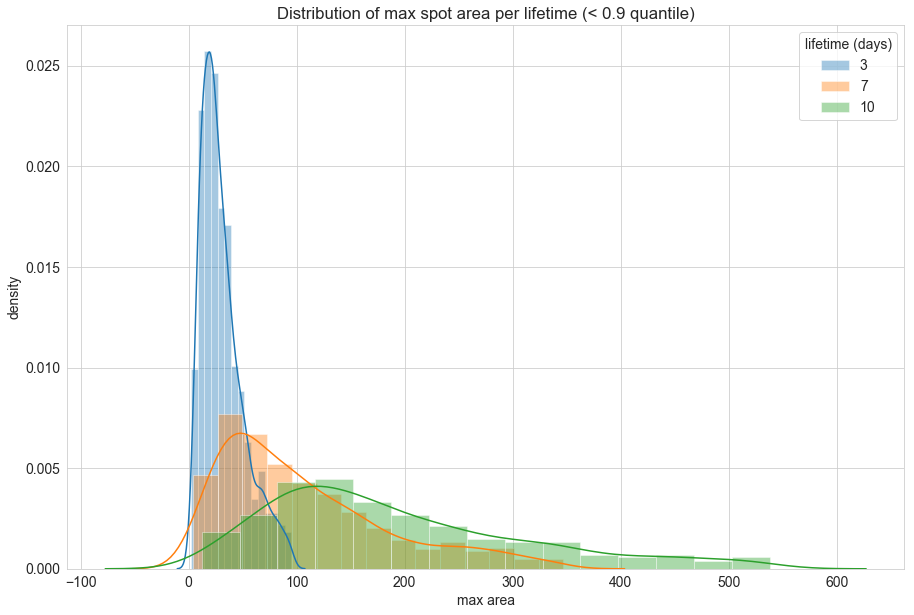

In [110]:
fig = plt.figure(figsize=(15, 10))
grouped_data = data.groupby('id')

for days in [3, 7, 10]:
    areas = grouped_data.max().corr_whole_area[grouped_data.size() == days]
    qt = np.quantile(areas, 0.9)
    sns.distplot(areas[areas < qt], bins=15, label=str(days))

plt.xlabel('max area')
plt.ylabel('density')
plt.legend(title='lifetime (days)')
plt.title('Distribution of max spot area per lifetime (< 0.9 quantile)')
plt.show()

In [8]:
class SequenceGenerator:
    def __init__(self, filter_area=35.0, filter_longitude=60.0, verbose=False):
        self.filter_area = filter_area
        self.filter_longitude = filter_longitude
        self.verbose = verbose
        
    def transform(self, data, filter_nan=True, filter_center=True, filter_right_edge=False, length=3):
        if filter_nan:
            nan_id = data.id[data.corr_whole_area.isna()].unique()
            train_data = data[~np.isin(data.id, nan_id)]
        else:
            train_data = data.fillna(0.0)
        grouped_data = train_data.groupby('id')

        spot_histories = np.full((grouped_data.ngroups, grouped_data.size().max()), np.nan)
        for i, (spot_id, group) in enumerate(tqdm(grouped_data,
                                               desc='Extracting histories',
                                               disable=not self.verbose)):
            if filter_center:
                mask = (np.abs(group.center_meridian_dist) < self.filter_longitude) & \
                   (group.corr_whole_area > self.filter_area)
                history = group.corr_whole_area[mask]
            elif filter_right_edge:
                zeros = np.zeros(max(0, length - group.corr_whole_area.size))
                history = np.append(zeros, group.corr_whole_area)
            else:
                history = group.corr_whole_area
            spot_histories[i, :history.size] = history
        
        mask = ~np.all(np.isnan(spot_histories), axis=1)
        spot_histories = spot_histories[mask, :]
        
        if filter_right_edge:
            left_edge_mask = grouped_data.center_meridian_dist.min() > -self.filter_longitude
            right_edge_mask = grouped_data.center_meridian_dist.max() > self.filter_longitude
            return spot_histories, left_edge_mask, right_edge_mask
        else:
            return spot_histories

In [9]:
class VectorTransformer:
    def __init__(self, length=3, filter_descending=False):
        self.length = length
        self.filter_descending = filter_descending
    
    def generate_subarrays(self, array):
        return scipy.linalg.hankel(array[:-self.length], array[-self.length - 1: -1])
    
    def generate_targets(self, array):
        return array[self.length:]
    
    def transform(self, sequences):
        X = np.apply_along_axis(self.generate_subarrays, 1, sequences)
        X = X.reshape((sequences.shape[0] * (sequences.shape[1] - self.length), self.length))
        y = np.apply_along_axis(self.generate_targets, 1, sequences)
        y = y.reshape(sequences.shape[0] * (sequences.shape[1] - self.length))
        mask = ~np.any(np.isnan(X), axis=1) & ~np.isnan(y)
        X, y = X[mask], y[mask]
        if self.filter_descending:
            mask = np.all(np.diff(np.concatenate((X, y.reshape(-1, 1)), axis=1)) < 0, axis=-1)
            X, y = X[mask], y[mask]
        return X, y

In [10]:
seq_gen = SequenceGenerator(filter_area=0, filter_longitude=100, verbose=True)
histories = seq_gen.transform(data)

In [13]:
vec_trans = VectorTransformer(length=1)
X, y = vec_trans.transform(histories)

In [14]:
seq_gen = SequenceGenerator(verbose=True, filter_area=35.0, filter_longitude=60.0)
histories_filtered = seq_gen.transform(data)

In [15]:
vec_trans = VectorTransformer(length=1)
X_filtered, y_filtered = vec_trans.transform(histories_filtered)

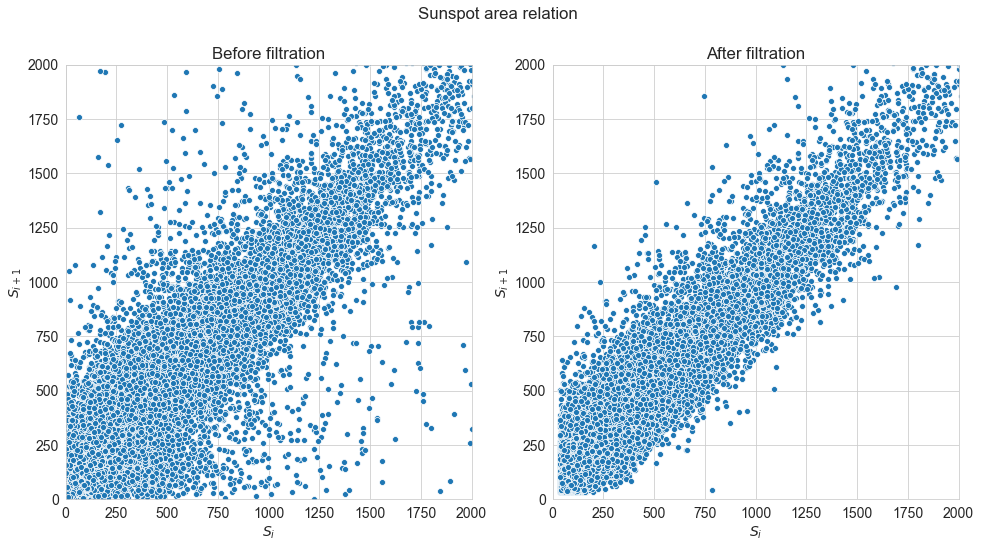

In [16]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(X[:, -1], y, ax=axs[0])
sns.scatterplot(X_filtered[:, -1], y_filtered, ax=axs[1])

for ax in axs:
    ax.set_xlim(0, 2000)
    ax.set_ylim(0, 2000)
    ax.set_xlabel(r'$S_{i}$')
    ax.set_ylabel(r'$S_{i+1}$')

axs[0].set_title('Before filtration')
axs[1].set_title('After filtration')
plt.suptitle('Sunspot area relation')
plt.show()

## Model Selection

In [10]:
def nan_mse(test, pred):
    mask = ~np.isnan(test)
    return ((test[mask] - pred[mask]) ** 2).sum() / mask.sum()

def nan_rmse(test, pred):
    return np.sqrt(nan_mse(test, pred))

def rmsle(test, pred):
    return ((np.log(test) - np.log(pred)) ** 2).sum() / test.size

def nan_rmsle(test, pred):
    mask = ~np.isnan(test)
    return rmsle(test[mask], pred[mask])

def nan_r2_score(test, pred):
    return 1 - nan_mse(test, pred) / np.nanvar(test)

def evaluate_model(regressor, sequences, length, metric=nan_mse, threshold=1.0):
    predicts = np.copy(sequences)
    for i in range(length, predicts.shape[1]):
        predicts[:, i] = np.maximum(threshold, regressor.predict(np.nan_to_num(predicts[:, i - length:i])))
    return metric(sequences[:, length:], predicts[:, length:])

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

class LinearModel:
    def __init__(self, scale=True, x_transform=None, y_transform=None, y_inverse_transform=None):
        self.x_transform = x_transform
        self.y_transform = y_transform
        self.y_inverse_transform = y_inverse_transform
        self.scaler = StandardScaler() if scale else None
        self.regressor = LinearRegression(fit_intercept=False)
    
    def fit(self, X, y):
        X_trans = self.x_transform(X) if self.x_transform else X
        X_trans = self.scaler.fit_transform(X_trans) if self.scaler else X_trans
        X_trans = np.append(X_trans, np.ones(X_trans.shape[0]).reshape((-1, 1)), axis=1)
        
        y_trans = self.y_transform(y) if self.y_transform else y
        self.regressor.fit(X_trans, y_trans)
        return self
    
    def predict(self, X):
        X_trans = self.x_transform(X) if self.x_transform else X
        X_trans = self.scaler.transform(X_trans) if self.scaler else X_trans
        X_trans = np.append(X_trans, np.ones(X_trans.shape[0]).reshape((-1, 1)), axis=1)
        
        y_pred_trans = self.regressor.predict(X_trans)
        y_pred = self.y_inverse_transform(y_pred_trans) if self.y_inverse_transform else y_pred_trans
        return y_pred

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

In [13]:
seq_gen = SequenceGenerator(verbose=True)
histories_filtered = seq_gen.transform(data)
train_histories, test_histories = train_test_split(histories_filtered, random_state=42)

In [24]:
vec_trans = VectorTransformer(length=3)
X_train, y_train = vec_trans.transform(train_histories)
X_test, y_test = vec_trans.transform(test_histories)

In [25]:
one_day_results = np.zeros((5, 26))
seq_results = np.zeros((5, 26))
for n in tqdm(range(1, 6)):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    for (i, k) in enumerate(range(1, 52, 2)):
        knn_regr = KNeighborsRegressor(n_neighbors=k)
        knn_regr.fit(X_train, y_train)
        one_day_results[n - 1, i] = np.sqrt(mean_squared_error(y_test, knn_regr.predict(X_test)))
        seq_results[n - 1, i] = evaluate_model(knn_regr, test_histories, n, nan_rmse, threshold=-np.inf)

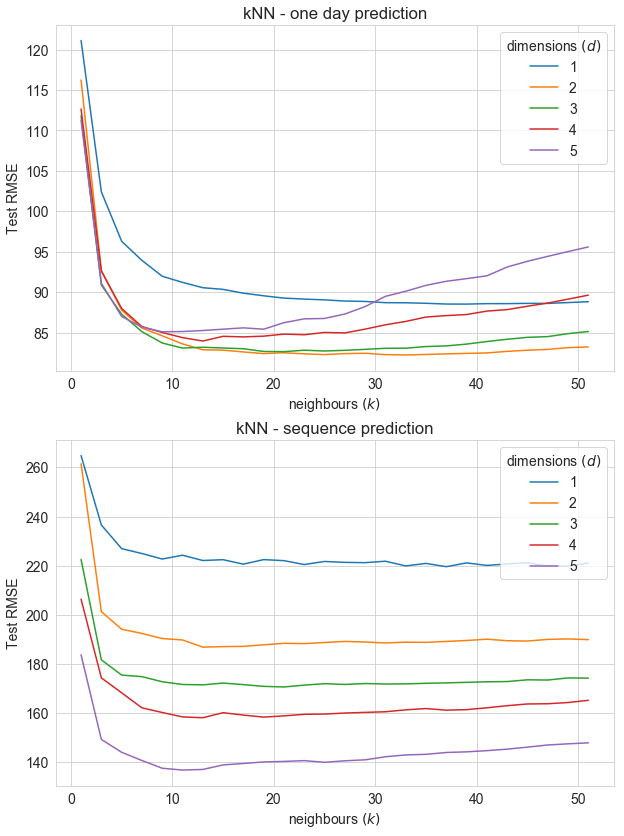

In [26]:
fig, axs = plt.subplots(figsize=(10, 14), nrows=2, ncols=1)

for i in range(5):
    sns.lineplot(range(1, 52, 2), one_day_results[i], label=str(i + 1), ax=axs[0])
    sns.lineplot(range(1, 52, 2), seq_results[i], label=str(i + 1), ax=axs[1])

for ax in axs:
    ax.legend(title=r'dimensions $(d)$', loc='upper right')
    ax.set_xlabel(r'neighbours $(k)$')
    ax.set_ylabel('Test RMSE')

axs[0].set_title('kNN - one day prediction')
axs[1].set_title('kNN - sequence prediction')
plt.show()

In [103]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

class BucketRegressor:
    def __init__(self, num_buckets=3, thresholds=None, regressor='linear', **kwargs):
        self.num_buckets = num_buckets
        self.thresholds = thresholds
        
        if regressor == 'linear':
            self.regressor = LinearRegression(**kwargs)
        elif regressor == 'loglinear':
            self.regressor = LinearModel(**kwargs)
        elif regressor == 'knn':
            self.regressor = DecisionTreeRegressor(**kwargs)
        
    def fit(self, X, y):
        if self.thresholds is None:
            self.thresholds = np.quantile(X[:, -1], np.linspace(0, 1, self.num_buckets + 1))
            self.thresholds[0] = -np.inf
            self.thresholds[-1] = np.inf
        else:
            self.thresholds = np.append(-np.inf, self.thresholds)
            self.thresholds = np.append(self.thresholds, np.inf)
        
        self.regressors = []
        for i in range(self.thresholds.size - 1):
            mask = (self.thresholds[i] <= X[:, -1]) & (X[:, -1] < self.thresholds[i + 1])
            if mask.sum() == 0:
                self.regressors.append(None)
            regressor = deepcopy(self.regressor)
            regressor.fit(X[mask], y[mask])
            self.regressors.append(regressor)
        return self
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(self.thresholds.size - 1):
            mask = (self.thresholds[i] <= X[:, -1]) & (X[:, -1] < self.thresholds[i + 1])
            if mask.sum() == 0:
                continue
            y[mask] = self.regressors[i].predict(X[mask]) if self.regressors[i] is not None else 0.0
            
        return y

In [27]:
one_day_results = np.zeros((5, 3))
seq_results = np.zeros((5, 3))
for n in range(1, 6):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    
    knn_regr = KNeighborsRegressor(n_neighbors=12)
    knn_regr.fit(X_train, y_train)
    one_day_results[n - 1, 0] = np.sqrt(mean_squared_error(y_test, knn_regr.predict(X_test)))
    seq_results[n - 1, 0] = evaluate_model(knn_regr, test_histories, n, nan_rmse, threshold=-np.inf)
        
    lin_regr = LinearRegression()
    lin_regr.fit(X_train, y_train)
    one_day_results[n - 1, 1] = np.sqrt(mean_squared_error(y_test, lin_regr.predict(X_test)))
    seq_results[n - 1, 1] = evaluate_model(lin_regr, test_histories, n, nan_rmse, threshold=-np.inf)
    
    log_regr = LinearModel(x_transform=np.log1p, y_transform=np.log1p, y_inverse_transform=np.expm1)
    log_regr.fit(X_train, y_train)
    one_day_results[n - 1, 2] = np.sqrt(mean_squared_error(y_test, log_regr.predict(X_test)))
    seq_results[n - 1, 2] = evaluate_model(log_regr, test_histories, n, nan_rmse, threshold=-np.inf)

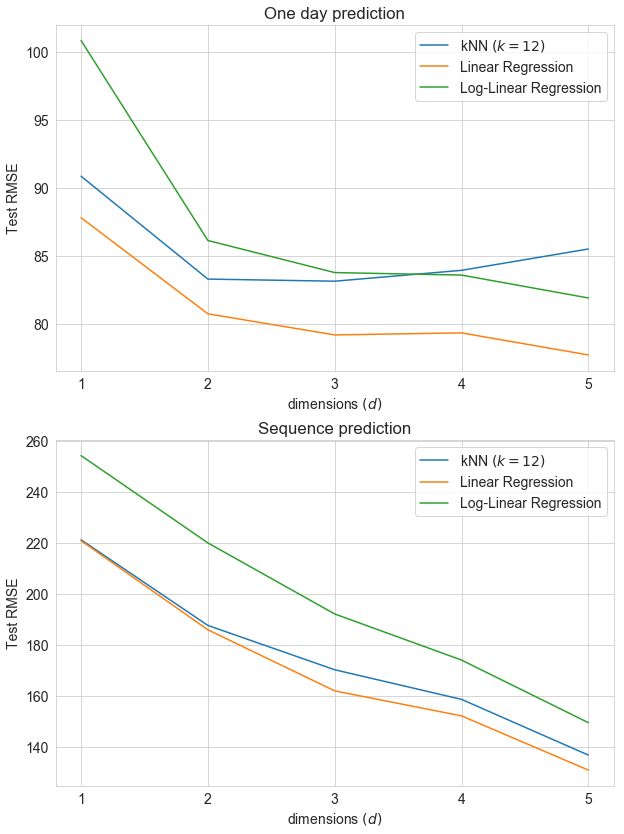

In [28]:
fig, axs = plt.subplots(figsize=(10, 14), nrows=2, ncols=1)

sns.lineplot(range(1, 6), one_day_results[:, 0], label='kNN $(k=12)$', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 0], label='kNN $(k=12)$', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 1], label='Linear Regression', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 1], label='Linear Regression', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 2], label='Log-Linear Regression', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 2], label='Log-Linear Regression', ax=axs[1])

for ax in axs:
    ax.legend(loc='upper right')
    ax.set_xlabel('dimensions $(d)$')
    ax.set_ylabel('Test RMSE')
    ax.set_xticks(range(1, 6))

axs[0].set_title('One day prediction')
axs[1].set_title('Sequence prediction')
plt.show()

In [29]:
one_day_results = np.zeros((5, 26))
seq_results = np.zeros((5, 26))
for n in tqdm(range(1, 6)):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    for (i, k) in enumerate(range(1, 52, 2)):
        knn_regr = KNeighborsRegressor(n_neighbors=k)
        knn_regr.fit(X_train, y_train)
        one_day_results[n - 1, i] = rmsle(y_test, knn_regr.predict(X_test))
        seq_results[n - 1, i] = evaluate_model(knn_regr, test_histories, n, nan_rmsle, threshold=1.0)

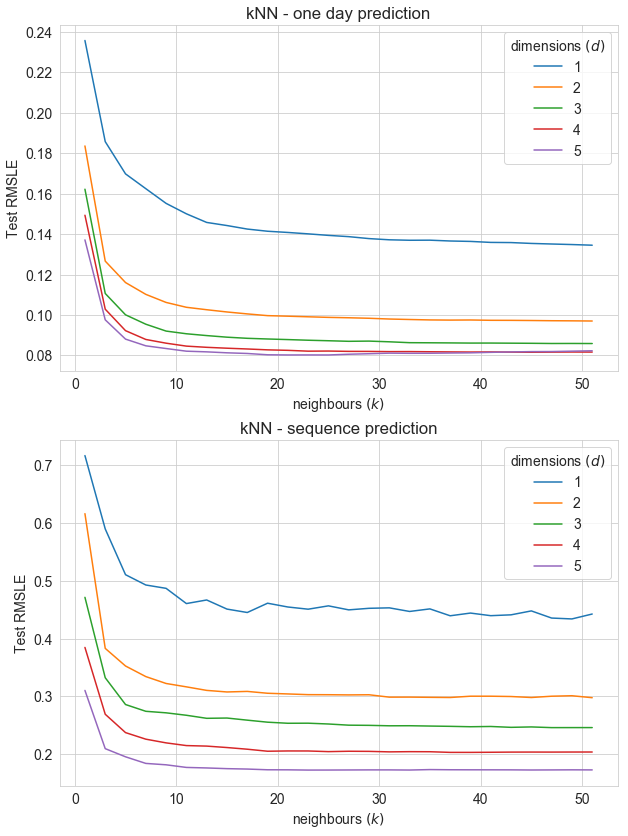

In [30]:
fig, axs = plt.subplots(figsize=(10, 14), nrows=2, ncols=1)

for i in range(5):
    sns.lineplot(range(1, 52, 2), one_day_results[i], label=str(i + 1), ax=axs[0])
    sns.lineplot(range(1, 52, 2), seq_results[i], label=str(i + 1), ax=axs[1])

for ax in axs:
    ax.legend(title=r'dimensions $(d)$', loc='upper right')
    ax.set_xlabel(r'neighbours $(k)$')
    ax.set_ylabel('Test RMSLE')

axs[0].set_title('kNN - one day prediction')
axs[1].set_title('kNN - sequence prediction')
plt.show()

In [31]:
one_day_results = np.zeros((5, 3))
seq_results = np.zeros((5, 3))
for n in range(1, 6):
    vec_trans = VectorTransformer(length=n)
    X_train, y_train = vec_trans.transform(train_histories)
    X_test, y_test = vec_trans.transform(test_histories)
    
    knn_regr = KNeighborsRegressor(n_neighbors=12)
    knn_regr.fit(X_train, y_train)
    one_day_results[n - 1, 0] = rmsle(y_test, knn_regr.predict(X_test))
    seq_results[n - 1, 0] = evaluate_model(knn_regr, test_histories, n, nan_rmsle, threshold=-np.inf)
    
    lin_regr = LinearRegression()
    lin_regr.fit(X_train, y_train)
    one_day_results[n - 1, 1] = rmsle(y_test, np.maximum(1.0, lin_regr.predict(X_test)))
    seq_results[n - 1, 1] = evaluate_model(lin_regr, test_histories, n, nan_rmsle, threshold=1.0)
    
    log_regr = LinearModel(x_transform=np.log1p, y_transform=np.log1p, y_inverse_transform=np.expm1)
    log_regr.fit(X_train, y_train)
    one_day_results[n - 1, 2] = rmsle(y_test, log_regr.predict(X_test))
    seq_results[n - 1, 2] = evaluate_model(log_regr, test_histories, n, nan_rmsle, threshold=-np.inf)

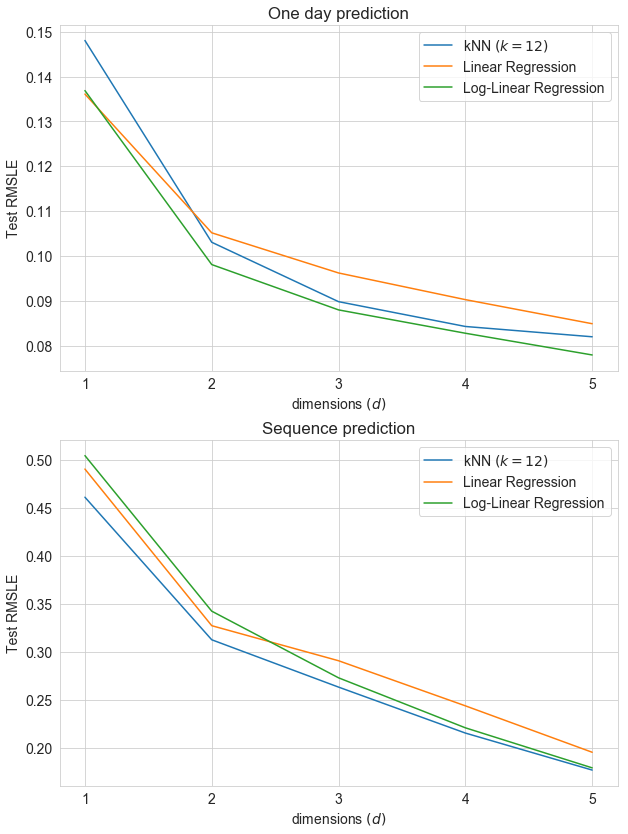

In [32]:
fig, axs = plt.subplots(figsize=(10, 14), nrows=2, ncols=1)

sns.lineplot(range(1, 6), one_day_results[:, 0], label='kNN $(k=12)$', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 0], label='kNN $(k=12)$', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 1], label='Linear Regression', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 1], label='Linear Regression', ax=axs[1])

sns.lineplot(range(1, 6), one_day_results[:, 2], label='Log-Linear Regression', ax=axs[0])
sns.lineplot(range(1, 6), seq_results[:, 2], label='Log-Linear Regression', ax=axs[1])

for ax in axs:
    ax.legend(loc='upper right')
    ax.set_xlabel('dimensions $(d)$')
    ax.set_ylabel('Test RMSLE')
    ax.set_xticks(range(1, 6))

axs[0].set_title('One day prediction')
axs[1].set_title('Sequence prediction')
plt.show()

In [14]:
class MultiDimensionalRegressor:
    def __init__(self, dimensions=np.arange(1, 6), fit_decrease=False, regressor=KNeighborsRegressor, **kwargs):
        self.dimensions = dimensions
        self.regressor = regressor(**kwargs)
        self.fit_decrease = fit_decrease
    
    def fit(self, histories):
        self.regressors = []
        for dim in self.dimensions:
            vec_trans = VectorTransformer(length=dim)
            X, y = vec_trans.transform(histories)
            if self.fit_decrease:
                mask = np.all(np.diff(np.concatenate((X, y.reshape(-1, 1)), axis=1)) < 0, axis=-1)
                X, y = X[mask], y[mask]
            regr = deepcopy(self.regressor)
            regr.fit(X, y)
            self.regressors.append(regr)
        return self
    
    def predict(self, X):
        y = np.zeros(X.shape[0])
        counts = (X != 0).sum(axis=1)
        for (dim, regr) in zip(self.dimensions, self.regressors):
            mask = (counts == dim)
            if mask.sum() == 0:
                continue
            y[mask] = regr.predict(X[mask, -dim:])
        return y

In [15]:
multidim_regr = MultiDimensionalRegressor(regressor=KNeighborsRegressor, fit_decrease=True,
                                          dimensions=np.arange(1, 5), n_neighbors=15)
multidim_regr.fit(train_histories)

## Decrease rate distribution

In [373]:
vec_trans = VectorTransformer(length=3)
X, y = vec_trans.transform(histories_filtered)
mask = np.all(np.diff(np.concatenate((X, y.reshape(-1, 1)), axis=1)) < 0, axis=-1)
X, y = X[mask], y[mask]

In [374]:
knn_regr = KNeighborsRegressor(n_neighbors=15)
knn_regr.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')

In [375]:
lin_model = LinearModel(x_transform=np.log1p, y_transform=np.log1p, y_inverse_transform=np.expm1)
lin_model.fit(X, y)

In [179]:
def reduce_to_center(data, q_min=0.025, q_max=0.975):
    (q_min, q_max) = np.quantile(data, (q_min, q_max))
    return data[(data > q_min) & (data < q_max)]

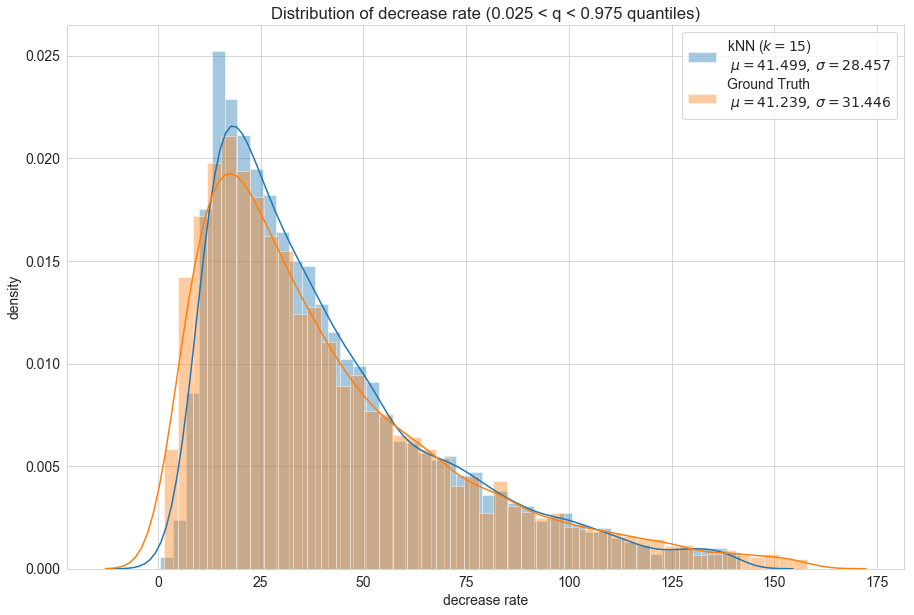

In [377]:
plt.figure(figsize=(15, 10))

knn_decrease = reduce_to_center((X[:, -2] - knn_regr.predict(X)) / 2, q_min=0, q_max=0.975)
lm_decrease = reduce_to_center((-lin_model.predict(X) + X[:, -2]) / 2)
true_decrease = reduce_to_center((X[:, -2] - y) / 2, q_min=0, q_max=0.975)

label = 'kNN ($k=15$)\n $\mu = {:.3f},\, \sigma = {:.3f}$'.format(np.mean(knn_decrease),
                                                                np.std(knn_decrease))
sns.distplot(knn_decrease, label=label)
'''
label = 'Log-Linear Regression\n $\mu = {:.3f},\, \sigma = {:.3f}$'.format(np.mean(lm_decrease),
                                                                           np.std(lm_decrease))
sns.distplot(lm_decrease, label=label)
'''
label = 'Ground Truth\n $\mu = {:.3f},\, \sigma = {:.3f}$'.format(np.mean(true_decrease),
                                                                  np.std(true_decrease))
sns.distplot(true_decrease, label=label)

plt.legend()
plt.title('Distribution of decrease rate (0.025 < q < 0.975 quantiles)')
plt.xlabel('decrease rate')
plt.ylabel('density')
plt.show()

## Decrease law regression

In [316]:
class PolynomialSeriesOracle:
    def __init__(self, F, t):
        self.F = F
        self.t = t

    def func(self, x):
        alpha, beta, gamma = x[0], x[1], x[2]
        series = alpha / (self.t ** gamma + beta)
        preds = self.F[:, 0].reshape((-1, 1)) @ series.reshape((1, -1))
        return 1 / 2 * np.mean((preds - self.F) ** 2)
    
    def grad(self, x):
        alpha, beta, gamma = x[0], x[1], x[2]
        denom = 1 / (self.t ** gamma + beta)
        S_0 = self.F[:, 0].reshape((-1, 1))
        preds = S_0 @ (alpha * denom).reshape((1, -1))
        base = preds - self.F
        
        series_grad = S_0 @ denom.reshape((1, -1))
        alpha_grad = np.mean(base * series_grad)
        
        series_grad = -alpha * S_0 @ (denom ** 2).reshape((1, -1))
        beta_grad = base * series_grad
        gamma_grad = np.mean(beta_grad * (np.log(t) * t ** gamma))
        beta_grad = np.mean(beta_grad)
        
        return np.array([alpha_grad, beta_grad, gamma_grad])

    def func_directional(self, x, d, alpha):
        return np.squeeze(self.func(x + alpha * d))

    def grad_directional(self, x, d, alpha):
        return np.squeeze(self.grad(x + alpha * d).dot(d))

In [238]:
from optimization import gradient_descent
from scipy.optimize import minimize

In [359]:
preds = list(X[2])
for i in range(20):
    preds.append(knn_regr.predict([preds[-5:]])[0])

In [360]:
preds

[427.0,
 389.0,
 350.0,
 312.0,
 273.0,
 228.66666666666666,
 187.33333333333334,
 156.4,
 119.8,
 94.73333333333333,
 67.33333333333333,
 45.6,
 32.46666666666667,
 27.333333333333332,
 25.333333333333332,
 25.666666666666668,
 25.666666666666668,
 25.733333333333334,
 25.733333333333334,
 25.733333333333334,
 25.733333333333334,
 25.733333333333334,
 25.733333333333334,
 25.733333333333334,
 25.733333333333334]

In [211]:
preds = np.array(preds).reshape((1, -1))

In [317]:
oracle = PolynomialSeriesOracle(preds, np.arange(1, 24))

In [318]:
from scipy.optimize import check_grad

In [319]:
check_grad(oracle.func, oracle.grad, np.array([1, 0, 1.5]))

0.00038248289528973586

In [320]:
res = minimize(oracle.func, np.array([1, 0, 1.5]), jac=oracle.grad, method='BFGS')

In [321]:
res

      fun: 207.88305469611893
 hess_inv: array([[0.00283547, 0.00296747, 0.00072101],
       [0.00296747, 0.00314942, 0.00074876],
       [0.00072101, 0.00074876, 0.0001895 ]])
      jac: array([-3.45788808e-07,  1.90264419e-07,  3.83795771e-07])
  message: 'Optimization terminated successfully.'
     nfev: 29
      nit: 23
     njev: 29
   status: 0
  success: True
        x: array([1.34168933, 0.33082483, 0.68040729])

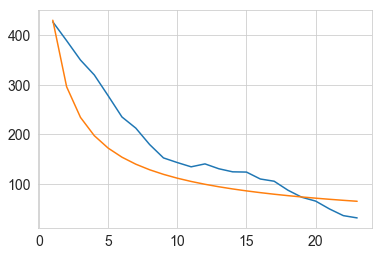

In [345]:
sns.lineplot(t, preds)
sns.lineplot(t, 1.34 * preds[0] / (t ** 0.68 + 0.33))

## Lifetime distribution

In [134]:
from scipy.ndimage import gaussian_filter1d

In [16]:
seq_gen = SequenceGenerator(verbose=True, filter_longitude=60)
histories_to_predict, left_mask, right_mask = seq_gen.transform(data, filter_center=False, filter_nan=True,
                                                                filter_right_edge=True, length=4)

In [266]:
multidim_regr = MultiDimensionalRegressor(regressor=KNeighborsRegressor, fit_decrease=True,
                                          dimensions=np.arange(1, 5), n_neighbors=10)
multidim_regr.fit(train_histories)

In [267]:
def predict_histories(regressor, sequences, length, threshold=1.0, filter_area=45.0, max_lifetime=30):
    predicts = np.full((sequences.shape[0], max_lifetime), np.nan)
    predicts[:, :sequences.shape[1]] = sequences
    
    for i in range(length, predicts.shape[1]):
        preds = np.maximum(threshold, regressor.predict(np.nan_to_num(predicts[:, i - length:i])))
        predicts[:, i] = np.where(np.isnan(predicts[:, i]), preds, predicts[:, i])
        rand_decrease = np.random.choice([True, False], p=(0, 1), size=preds.size)
        predicts[:, i] = np.where(rand_decrease, predicts[:, i - 1] / 3, predicts[:, i])
    
    predicts[:, length:] = np.where(predicts[:, length:] > filter_area, predicts[:, length:], 0)
    return predicts

def get_lifetimes(predicts, length):
    return length + np.argmin(predicts[:, length:], axis=1) - (predicts[:, :length] == 0).sum(axis=1)

In [268]:
new_histories = np.zeros((histories_to_predict.shape[0], 30))
new_histories[~right_mask, :histories_to_predict.shape[1]] = histories_to_predict[~right_mask]
new_histories[right_mask] = predict_histories(multidim_regr, histories_to_predict[right_mask], 4,
                                              filter_area=45.0, max_lifetime=30)

In [269]:
lifetimes = get_lifetimes(new_histories[left_mask], 4)

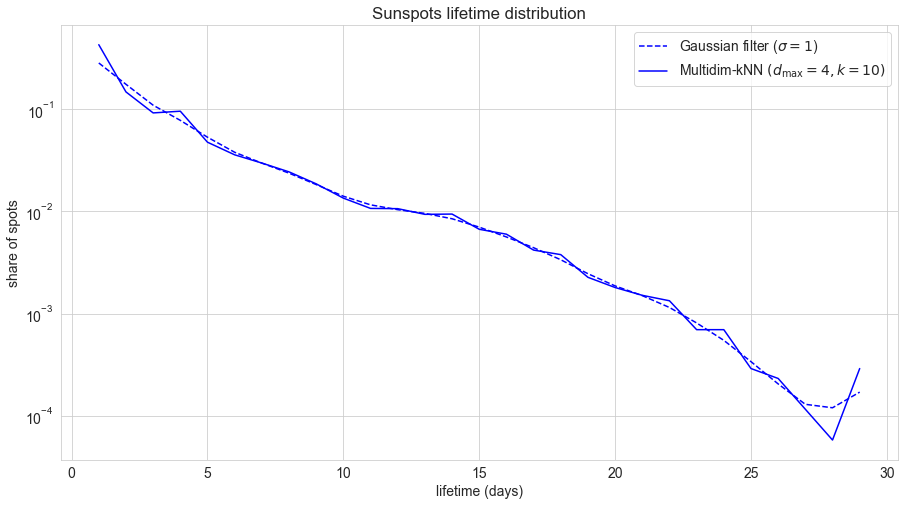

In [271]:
plt.figure(figsize=(15, 8))
unique, counts = np.unique(lifetimes, return_counts=True)
counts = counts / counts.sum()
ax = sns.lineplot(unique, np.exp(gaussian_filter1d(np.log(counts), 1)), color='blue',
                  label='Gaussian filter ($\sigma=1$)')
sns.lineplot(unique, counts, color='blue', label='Multidim-kNN $(d_{\max}=4, k=10)$')
ax.lines[0].set_linestyle("--")
plt.yscale('log')
plt.xlabel('lifetime (days)')
plt.ylabel('share of spots')
plt.title('Sunspots lifetime distribution')
plt.legend()
#plt.xscale('log')
plt.show()

$$
-\frac{dS}{dt} = \frac{\alpha}{S_0} \sqrt{S}
$$

$$
\frac{dS}{\sqrt{S}} = -\frac{\alpha}{S_0} dt
$$

$$
\int_{S_0}^{S}\frac{dS}{\sqrt{S}} = \int_{0}^{T}-\frac{\alpha}{S_0} dt
$$

$$
2\sqrt{S} - 2\sqrt{S_0} = -\frac{\alpha}{S_0} T
$$

$$
\sqrt{S} = \sqrt{S_0} - \frac{\alpha}{2 \sqrt{S_0}} T
$$

$$
S = \left(\sqrt{S_0} - \frac{\alpha}{2 \sqrt{S_0}} T \right)^2 = S_0 \left(1 - \frac{\alpha}{2 S_0} T \right)^2
$$

$$
T_{lt} \approx \frac{2 S_0}{\alpha} \Rightarrow \frac{S_0}{T_{lt}} = \frac{\alpha}{2} \approx \frac{86}{2} = 43
$$

In [217]:
new_histories = new_histories[left_mask]

In [233]:
decr_rates = np.array([])
area_ratios = np.array([])
gnev_wald = np.array([])
for i in tqdm(range(new_histories.shape[0])):
    seq = new_histories[i]
    mask = ~(np.isnan(seq) | (seq == 0))
    seq = seq[mask]
    seq = seq[np.argmax(seq):]
    if seq.size < 10 or not np.all(np.diff(seq) < 0):
        continue
    decr_rates = np.concatenate((decr_rates, (seq[:-2] - seq[2:]) / 2))
    area_ratios = np.concatenate((area_ratios, seq[1:-1] / np.max(seq)))
    gnev_wald = np.append(gnev_wald, np.max(seq) / mask.sum())

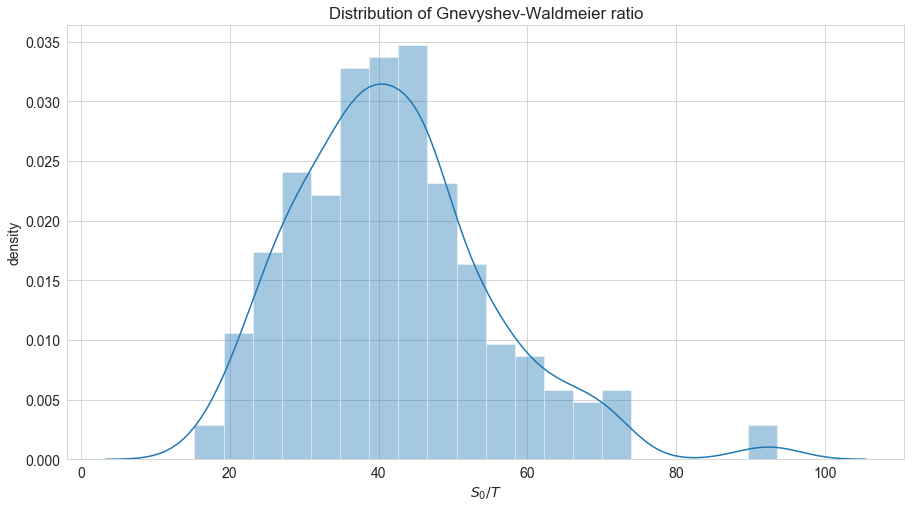

In [244]:
plt.figure(figsize=(15, 8))
sns.distplot(gnev_wald, bins=20)
plt.title('Distribution of Gnevyshev-Waldmeier ratio')
plt.xlabel(r'$S_0 / T$')
plt.ylabel('density')
plt.show()

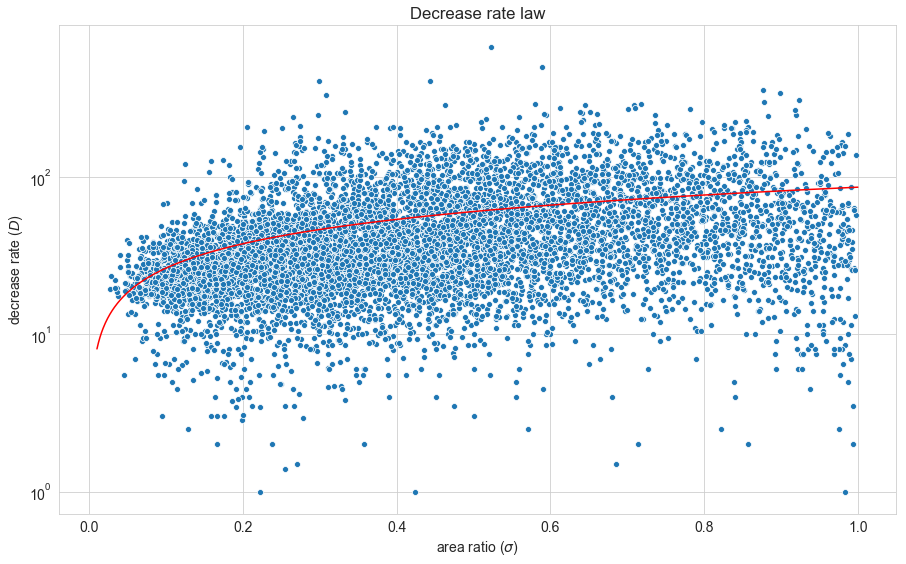

In [225]:
plt.figure(figsize=(15, 9))

sns.scatterplot(area_ratios, decr_rates)
sns.lineplot(np.linspace(0.01, 1, 1000), 85.979 * np.linspace(0.01, 1, 1000) ** 0.514, color='red')

plt.xlabel('area ratio ($\sigma$)')
plt.ylabel('decrease rate ($D$)')
plt.title('Decrease rate law')
plt.yscale('log')

In [282]:
class DecreaseRateOracle:
    def __init__(self, D, sigma):
        self.D = D
        self.sigma = sigma
    
    def func(self, x):
        alpha, gamma = x[0], x[1]
        hat_D = alpha * self.sigma ** gamma
        return 1 / 2 * np.mean((np.log(hat_D) - np.log(self.D)) ** 2)
    
    def grad(self, x):
        alpha, gamma = x[0], x[1]
        hat_D = alpha * self.sigma ** gamma
        base = (np.log(hat_D) - np.log(self.D))
        alpha_grad = np.mean(base / alpha)
        gamma_grad = np.mean(base * np.log(self.sigma))
        return np.array([alpha_grad, gamma_grad])

In [283]:
oracle = DecreaseRateOracle(D=decr_rates, sigma=area_ratios)

In [284]:
from scipy.optimize import minimize

In [285]:
minimize(oracle.func, x0=np.array([1, 0]), method='BFGS', jac=oracle.grad)

      fun: 0.12560348230710286
 hess_inv: array([[2.64018360e+04, 1.90895441e+02],
       [1.90895441e+02, 1.90789656e+00]])
      jac: array([ 4.74602517e-08, -5.49447290e-06])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 20
     njev: 21
   status: 0
  success: True
        x: array([85.97926806,  0.51375309])

In [286]:
oracle.func(np.array([83.40401383,  3.88801951,  0.5677497 ]))

10.993068135103972

In [287]:
oracle.func(np.array([85.97926806,  0.51375309]))

0.12560348230710833

In [386]:
sample = reduce_to_center(decr_rates, q_min=0.0, q_max=0.975)

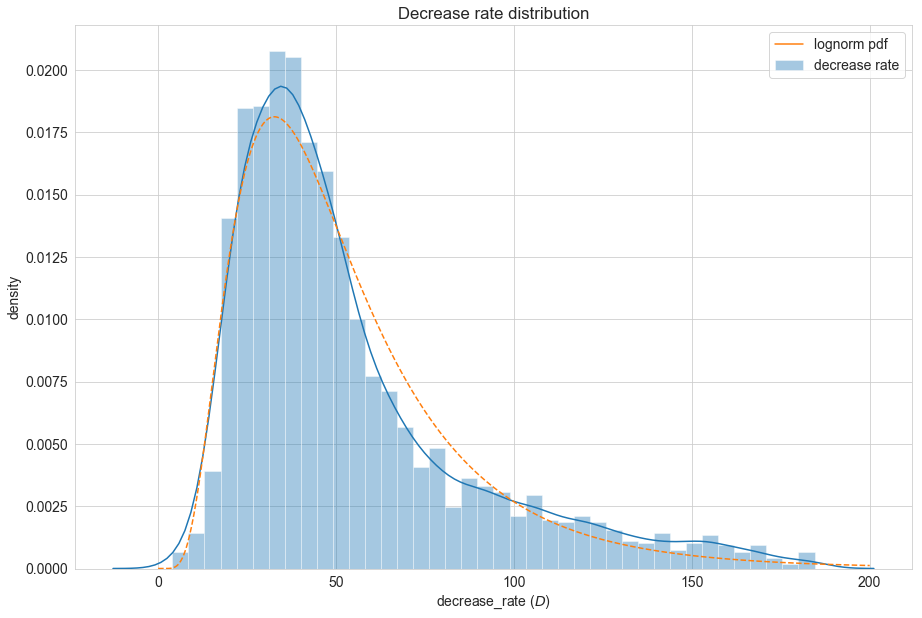

In [400]:
plt.figure(figsize=(15, 10))
s, theta = np.std(np.log(sample)), np.exp(np.mean(np.log(sample)))
sns.distplot(sample, bins=40, label='decrease rate')
ax = sns.lineplot(np.linspace(0, 200, 1000), scipy.stats.lognorm.pdf(np.linspace(0, 200, 1000), s=s, scale=theta),
                  label='lognorm pdf')
ax.lines[1].set_linestyle("--")

plt.xlabel('decrease_rate ($D$)')
plt.ylabel('density')
plt.title('Decrease rate distribution')
plt.show()

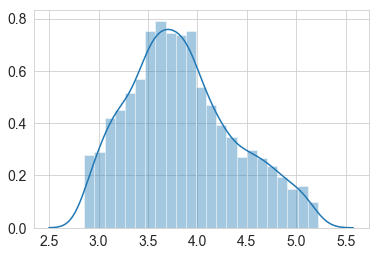

In [385]:
sns.distplot(np.log(reduce_to_center(decr_rates)))

In [314]:
np.mean(np.log(reduce_to_center(decr_rates))), np.std(np.log(reduce_to_center(decr_rates)))

(3.8461464854960887, 0.5411194947636663)

In [317]:
np.exp(3.846)

46.805466422400336